In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from SSTImportanceSampling  import Preprocessor, ImportanceSampler, StormDepthProcessor, AdaptParams, AdaptiveMixtureSampler

from production.utils import summarize_depths_by_return_period
from production.metrics import metrics
from production.plots import plot_return_period_summary, plot_two_return_period_summaries


In [3]:
watershed_names = ["Trinity","Kanawha","Duwamish","Denton"]

In [4]:
#Load data
watersheds = {}

for wname in watershed_names:
    ws = Preprocessor.load(
        config_path=f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{wname}/config.json"
    )
    watersheds[wname] = ws

In [6]:
#Full Monte Carlo summary
base_dir = "/workspaces/Importance-Sampling-for-SST/data/2_production"
summary_filename = "fullmonte_summary.pq"

# --- load summaries ---
summaries = {}
for w in watershed_names:
    path = os.path.join(base_dir, w, summary_filename)
    df = pd.read_parquet(path)
    needed = {"RP","median_in","ci95_low_in","ci95_high_in"}
    if not needed <= set(df.columns):
        raise ValueError(f"{w}: summary missing columns {needed - set(df.columns)}")
    summaries[w] = df.sort_values("RP")

In [43]:
watershed_name = "Kanawha"
watershed = watersheds[watershed_name]

# ----- fixed sampler params -----
params = {
    "mu_x": watershed.watershed_stats["x"],  
    "mu_y": watershed.watershed_stats["y"],      
    "sd_x": watershed.watershed_stats["range_x"]*1,
    "sd_y": watershed.watershed_stats["range_y"]*0.5,
    "rho": -0.6,                             
}

# where to save depths
out_dir = f"/workspaces/Importance-Sampling-for-SST/data/2_production/{watershed_name}"
os.makedirs(out_dir, exist_ok=True)

# baseline obs/target summary to compare against
baseline_summary = summaries[watershed_name]

metrics_rows = []

sampler = ImportanceSampler(
    distribution="gaussian_copula",
    params=params,
    num_simulations=12000,
    num_realizations=50,   # keep fixed
)
copula_samples = sampler.sample(data=watershed)

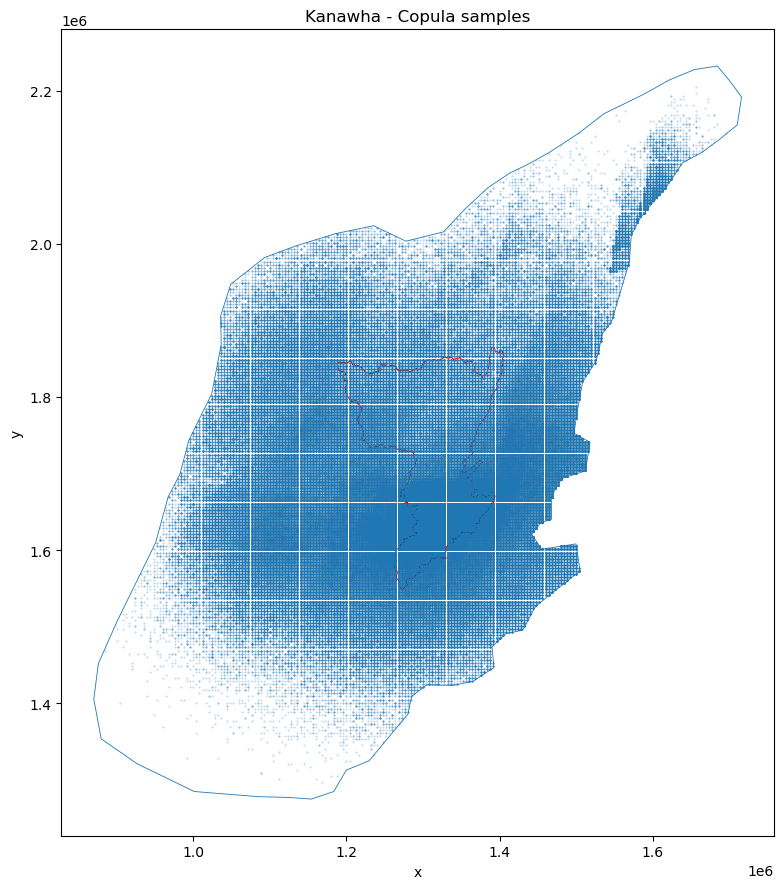

In [44]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
watershed.watershed_gdf.plot(ax=ax, linewidth=0.6, edgecolor='red', facecolor='none') 
plt.scatter(copula_samples.newx, copula_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - Copula samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [ ]:
# ---- depths ----
copula_depths = StormDepthProcessor(watershed).run(copula_samples, n_jobs=-1)

# save depths parquet
depths_path = os.path.join(out_dir, f"copula_depths_ns12000.pq")
copula_depths.to_parquet(depths_path, index=False)

    # ---- summarize ----
mixture_summary = summarize_depths_by_return_period(
    df=copula_depths,
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,
    rp_min=2,
    rp_max_cap=2000,
)

    # ---- metrics vs baseline ----
m = metrics(baseline_summary, mixture_summary)
m["num_simulations"] = 12000
metrics_rows.append(m)

# final metrics table
metrics_table = pd.concat(metrics_rows, ignore_index=True)
metrics_table
metrics_path = os.path.join(out_dir, f"trunc_norm_metrics.pq")
metrics_table.to_parquet(metrics_path, index=False)

In [46]:
metrics_table

,n_points,rp_min_used,rp_max_used,rmse_mean,rmse_median,rmse_ci95_low,rmse_ci95_high,rmse_ci90_low,rmse_ci90_high,me_mean,...,me_ci95_high,me_ci90_low,me_ci90_high,diff_at_maxrp_mean,diff_at_maxrp_median,diff_at_maxrp_ci95_low,diff_at_maxrp_ci95_high,diff_at_maxrp_ci90_low,diff_at_maxrp_ci90_high,num_simulations
0,1999,2.0,2000.0,0.03326,0.036619,0.066865,0.053565,0.060645,0.049536,-0.030951,...,-0.02509,-0.045299,-0.030668,-0.024887,-0.025162,0.107729,-0.044718,0.033155,-0.038958,12000


In [125]:
watershed_name = "Trinity"
watershed = watersheds[watershed_name]

# ----- fixed sampler params -----
params = {
    "mu_x": watershed.watershed_stats["x"],  
    "mu_y": watershed.watershed_stats["y"],      
    "sd_x": watershed.watershed_stats["range_x"]*0.8,
    "sd_y": watershed.watershed_stats["range_y"]*0.35,
    "rho": -0.2,                             
}

# where to save depths
out_dir = f"/workspaces/Importance-Sampling-for-SST/data/2_production/{watershed_name}"
os.makedirs(out_dir, exist_ok=True)

# baseline obs/target summary to compare against
baseline_summary = summaries[watershed_name]

metrics_rows = []

sampler = ImportanceSampler(
    distribution="gaussian_copula",
    params=params,
    num_simulations=12000,
    num_realizations=50,   # keep fixed
)
copula_samples = sampler.sample(data=watershed)

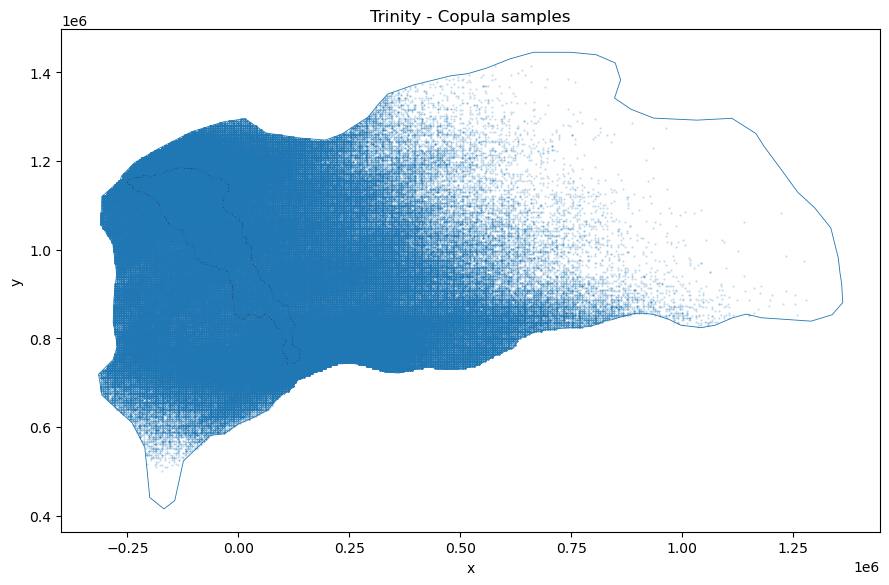

In [126]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
watershed.watershed_gdf.plot(ax=ax, linewidth=0.6, edgecolor='red', facecolor='none') 
plt.scatter(copula_samples.newx, copula_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - Copula samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [127]:
# ---- depths ----
copula_depths = StormDepthProcessor(watershed).run(copula_samples, n_jobs=-1)

# save depths parquet
depths_path = os.path.join(out_dir, f"copula_depths_ns12000.pq")
copula_depths.to_parquet(depths_path, index=False)

# ---- summarize ----
copula_summary = summarize_depths_by_return_period(
    df=copula_depths,
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,
    rp_min=2,
    rp_max_cap=2000,
)

    # ---- metrics vs baseline ----
m = metrics(baseline_summary, copula_summary)
m["num_simulations"] = 12000
metrics_rows.append(m)

# final metrics table
metrics_table = pd.concat(metrics_rows, ignore_index=True)
metrics_table
metrics_path = os.path.join(out_dir, f"copula_metrics.pq")
metrics_table.to_parquet(metrics_path, index=False)

In [139]:
copula_depths

,event_id,storm_path,x,y,weight,precip_avg_mm,realization,realization_seed,exc_prb
0,1,19800120_72hr_st1_r320,178953.060874,8.415483e+05,0.000118,35.642113,1,1.230933e+19,0.590202
1,2,19940228_72hr_st1_r433,278953.060874,1.045548e+06,0.000042,41.397362,1,1.230933e+19,0.544253
2,3,19990311_72hr_st1_r231,-141046.939126,7.775483e+05,0.000149,57.857895,1,1.230933e+19,0.417469
3,4,19950731_72hr_st2_r139,-17046.939126,1.057548e+06,0.000071,124.739479,1,1.230933e+19,0.088019
4,5,20100925_72hr_st5_r419,262953.060874,9.775483e+05,0.000043,13.245614,1,1.230933e+19,0.774190
...,...,...,...,...,...,...,...,...,...
599995,11996,20050325_72hr_st1_r132,94953.060874,9.575483e+05,0.000046,16.955263,50,1.182486e+19,0.747889
599996,11997,20090314_72hr_st1_r295,-5046.939126,1.157548e+06,0.000035,120.924553,50,1.182486e+19,0.102716
599997,11998,19871108_72hr_st1_r163,286953.060874,9.015483e+05,0.000121,37.899120,50,1.182486e+19,0.577056
599998,11999,19870613_72hr_st3_r424,-205046.939126,1.069548e+06,0.000030,77.491219,50,1.182486e+19,0.294849


In [128]:
metrics_table

,n_points,rp_min_used,rp_max_used,rmse_mean,rmse_median,rmse_ci95_low,rmse_ci95_high,rmse_ci90_low,rmse_ci90_high,me_mean,...,me_ci95_high,me_ci90_low,me_ci90_high,diff_at_maxrp_mean,diff_at_maxrp_median,diff_at_maxrp_ci95_low,diff_at_maxrp_ci95_high,diff_at_maxrp_ci90_low,diff_at_maxrp_ci90_high,num_simulations
0,1455,2.0,1456.0,0.033674,0.036061,0.130644,0.041023,0.120499,0.036533,0.031506,...,0.0087,0.075736,0.018053,0.042847,0.041782,0.126967,0.004978,0.115999,0.003421,12000


In [136]:
watershed_name = "Denton"
watershed = watersheds[watershed_name]

# ----- fixed sampler params -----
params = {
    "mu_x": watershed.watershed_stats["x"],  
    "mu_y": watershed.watershed_stats["y"],      
    "sd_x": watershed.watershed_stats["range_x"]*6,
    "sd_y": watershed.watershed_stats["range_y"]*3,
    "rho": 0.4,                             
}

# where to save depths
out_dir = f"/workspaces/Importance-Sampling-for-SST/data/2_production/{watershed_name}"
os.makedirs(out_dir, exist_ok=True)

# baseline obs/target summary to compare against
baseline_summary = summaries[watershed_name]

metrics_rows = []

sampler = ImportanceSampler(
    distribution="gaussian_copula",
    params=params,
    num_simulations=12000,
    num_realizations=50,   # keep fixed
)
copula_samples = sampler.sample(data=watershed)

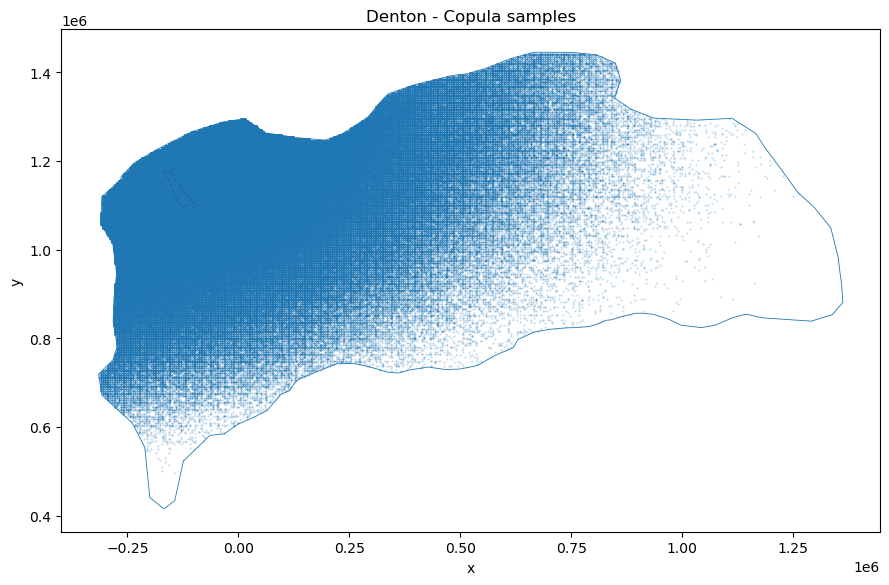

In [137]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
watershed.watershed_gdf.plot(ax=ax, linewidth=0.6, edgecolor='red', facecolor='none') 
plt.scatter(copula_samples.newx, copula_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - Copula samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [138]:
# ---- depths ----
copula_depths = StormDepthProcessor(watershed).run(copula_samples, n_jobs=-1)

# save depths parquet
depths_path = os.path.join(out_dir, f"copula_depths_ns12000.pq")
copula_depths.to_parquet(depths_path, index=False)

# ---- summarize ----
copula_summary = summarize_depths_by_return_period(
    df=copula_depths,
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,
    rp_min=2,
    rp_max_cap=2000,
)

    # ---- metrics vs baseline ----
m = metrics(baseline_summary, copula_summary)
m["num_simulations"] = 12000
metrics_rows.append(m)

# final metrics table
metrics_table = pd.concat(metrics_rows, ignore_index=True)
metrics_table
metrics_path = os.path.join(out_dir, f"copula_metrics.pq")
metrics_table.to_parquet(metrics_path, index=False)

KeyboardInterrupt: 

In [133]:
metrics_table

,n_points,rp_min_used,rp_max_used,rmse_mean,rmse_median,rmse_ci95_low,rmse_ci95_high,rmse_ci90_low,rmse_ci90_high,me_mean,...,me_ci95_high,me_ci90_low,me_ci90_high,diff_at_maxrp_mean,diff_at_maxrp_median,diff_at_maxrp_ci95_low,diff_at_maxrp_ci95_high,diff_at_maxrp_ci90_low,diff_at_maxrp_ci90_high,num_simulations
0,1819,2.0,1820.0,0.289959,0.547788,0.859671,0.931209,0.722957,0.779017,0.159009,...,0.455336,0.164757,0.21916,0.383642,0.850669,0.762177,0.280617,0.045389,0.013201,12000


In [ ]:
watershed_name = "Duwamish"
watershed = watersheds[watershed_name]

# ----- fixed sampler params -----
params = {
    "mu_x": watershed.watershed_stats["x"],  
    "mu_y": watershed.watershed_stats["y"],      
    "sd_x": watershed.watershed_stats["range_x"]*6,
    "sd_y": watershed.watershed_stats["range_y"]*3,
    "rho": -0.2,                             
}

# where to save depths
out_dir = f"/workspaces/Importance-Sampling-for-SST/data/2_production/{watershed_name}"
os.makedirs(out_dir, exist_ok=True)

# baseline obs/target summary to compare against
baseline_summary = summaries[watershed_name]

metrics_rows = []

sampler = ImportanceSampler(
    distribution="gaussian_copula",
    params=params,
    num_simulations=12000,
    num_realizations=50,   # keep fixed
)
copula_samples = sampler.sample(data=watershed)

In [ ]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
watershed.watershed_gdf.plot(ax=ax, linewidth=0.6, edgecolor='red', facecolor='none') 
plt.scatter(copula_samples.newx, copula_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - Copula samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [ ]:
# ---- depths ----
copula_depths = StormDepthProcessor(watershed).run(copula_samples, n_jobs=-1)

# save depths parquet
depths_path = os.path.join(out_dir, f"copula_depths_ns12000.pq")
copula_depths.to_parquet(depths_path, index=False)

# ---- summarize ----
copula_summary = summarize_depths_by_return_period(
    df=copula_depths,
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,
    rp_min=2,
    rp_max_cap=2000,
)

    # ---- metrics vs baseline ----
m = metrics(baseline_summary, copula_summary)
m["num_simulations"] = 12000
metrics_rows.append(m)

# final metrics table
metrics_table = pd.concat(metrics_rows, ignore_index=True)
metrics_table
metrics_path = os.path.join(out_dir, f"copula_metrics.pq")
metrics_table.to_parquet(metrics_path, index=False)

In [17]:
duwamish_depths = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/2_production/Duwamish/truncnorm_depths_ns15000.pq")
kanawha_depths = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/2_production/Kanawha/truncnorm_depths_ns15000.pq")
trinity_depths = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/2_production/Trinity/truncnorm_depths_ns15000.pq")
denton_depths = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/2_production/Denton/truncnorm_depths_ns15000.pq")

duwamish_summary = summarize_depths_by_return_period(df=duwamish_depths,precip_col="precip_avg_mm",exc_col="exc_prb",realization_col="realization",k=10.0,rp_min=2,rp_max_cap=2000,)
kanawha_summary = summarize_depths_by_return_period(df=kanawha_depths,precip_col="precip_avg_mm",exc_col="exc_prb",realization_col="realization",k=10.0,rp_min=2,rp_max_cap=2000,)
trinity_summary = summarize_depths_by_return_period(df=trinity_depths,precip_col="precip_avg_mm",exc_col="exc_prb",realization_col="realization",k=10.0,rp_min=2,rp_max_cap=2000,)
denton_summary = summarize_depths_by_return_period(df=denton_depths,precip_col="precip_avg_mm",exc_col="exc_prb",realization_col="realization",k=10.0,rp_min=2,rp_max_cap=2000,)

#Full Monte Carlo summary
base_dir = "/workspaces/Importance-Sampling-for-SST/data/1_interim"
summary_filename = "fullmonte_summary.pq"

# --- load summaries ---
summaries = {}
for w in watershed_names:
    path = os.path.join(base_dir, w, summary_filename)
    df = pd.read_parquet(path)
    needed = {"RP","median_in","ci95_low_in","ci95_high_in"}
    if not needed <= set(df.columns):
        raise ValueError(f"{w}: summary missing columns {needed - set(df.columns)}")
    summaries[w] = df.sort_values("RP")

Saved: /workspaces/Importance-Sampling-for-SST/data/2_production/plots/fullmonte_vs_truncnorm_precip_frequency.png


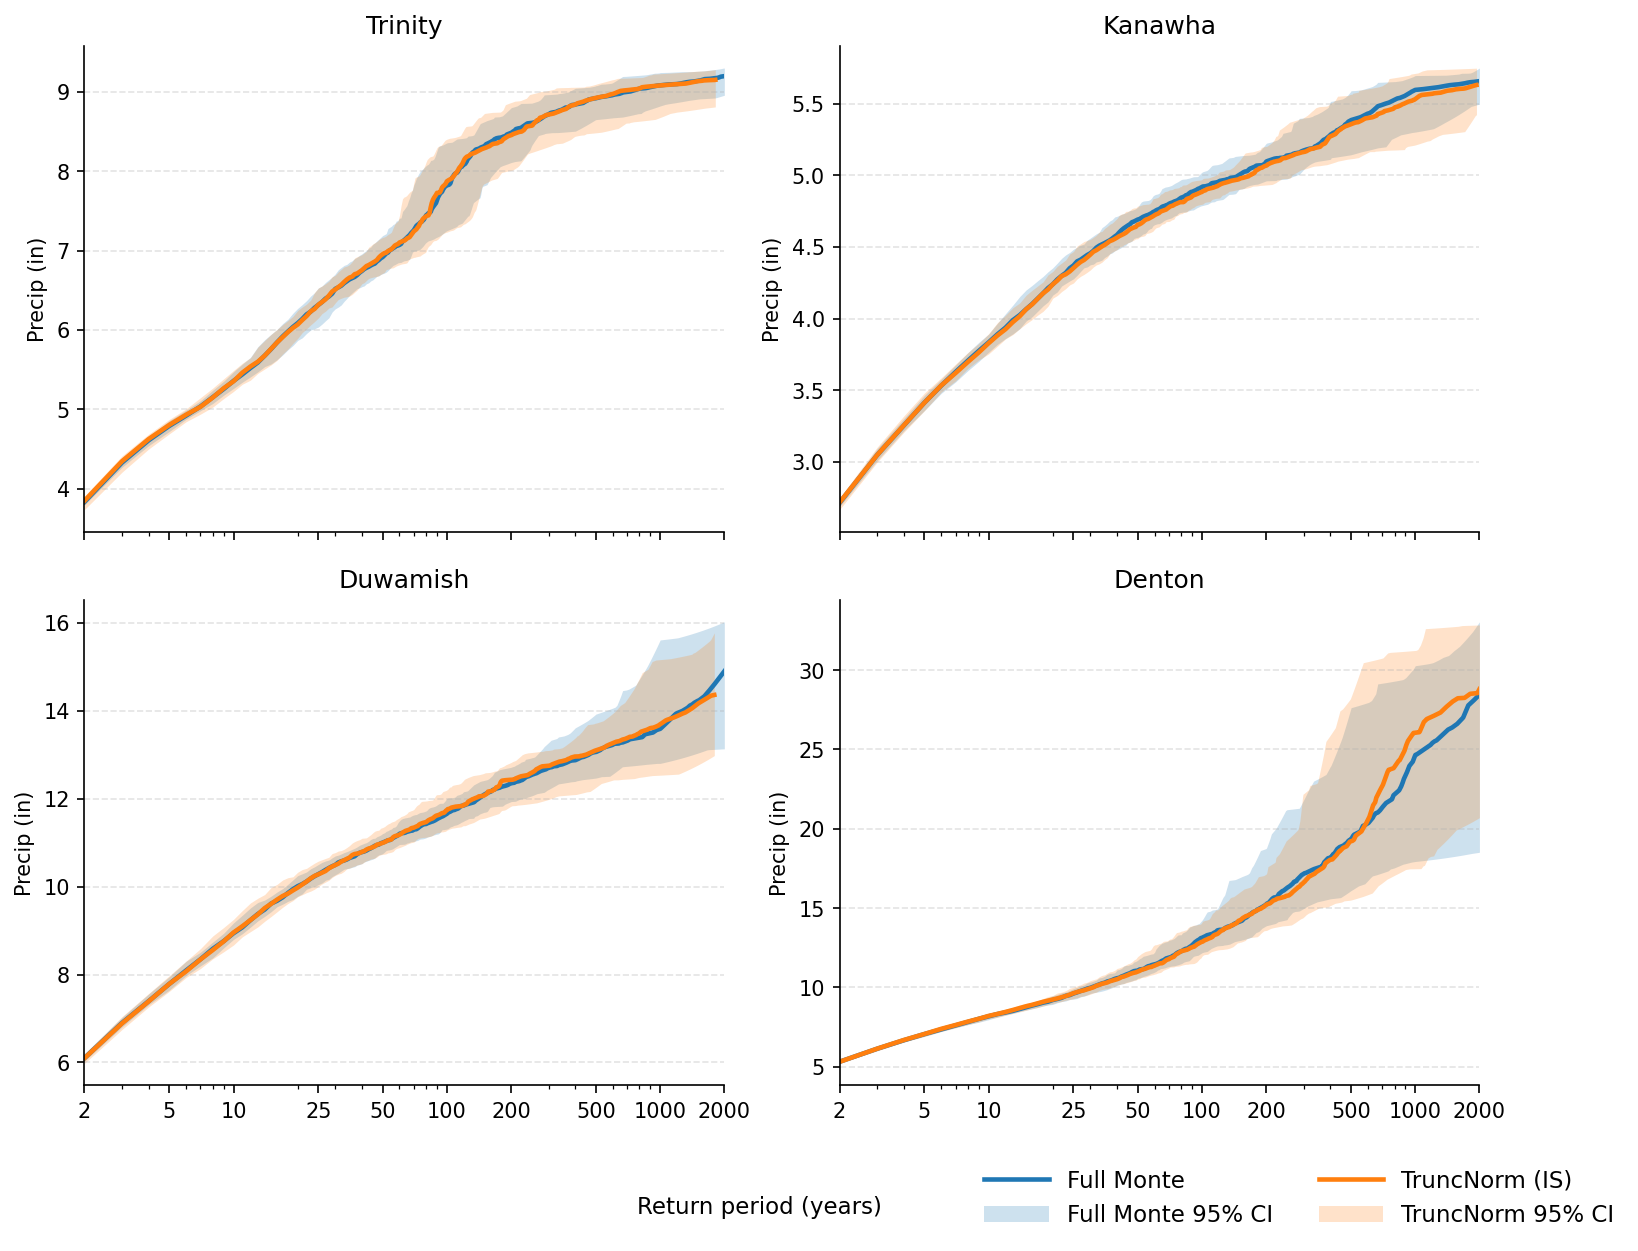

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# ---------------------------
# 1) Collect mixture summaries
# ---------------------------
mixture_by_ws = {
    "Duwamish": duwamish_summary.copy(),
    "Kanawha":  kanawha_summary.copy(),
    "Trinity":  trinity_summary.copy(),
    "Denton":   denton_summary.copy(),
}

def ensure_inches(df):
    """
    Ensure the summary has columns: RP, median_in, ci95_low_in, ci95_high_in.
    Converts from *_mm if needed.
    """
    out = df.copy()
    # normalize column names (common possibilities)
    cols = set(out.columns)

    # already in inches?
    need_in = {"RP","median_in","ci95_low_in","ci95_high_in"}
    if need_in <= cols:
        return out.sort_values("RP")

    # try mm -> in
    mm_sets = [
        {"median_mm","ci95_low_mm","ci95_high_mm"},
        {"median","ci95_low","ci95_high"},  # assume these are mm if not labeled
    ]
    for mm_set in mm_sets:
        if mm_set <= cols:
            out["median_in"]    = out[list(mm_set)[0]] / 25.4
            # be explicit to avoid order ambiguity
            out["ci95_low_in"]  = out["ci95_low_mm"]  / 25.4 if "ci95_low_mm"  in cols else out["ci95_low"]  / 25.4
            out["ci95_high_in"] = out["ci95_high_mm"] / 25.4 if "ci95_high_mm" in cols else out["ci95_high"] / 25.4
            return out[["RP","median_in","ci95_low_in","ci95_high_in"]].sort_values("RP")

    raise ValueError("Summary is missing required columns (RP & median/CI in inches or mm).")

# inches-ify mixture
for w in mixture_by_ws:
    mixture_by_ws[w] = ensure_inches(mixture_by_ws[w])

# Full Monte already loaded into `summaries` dict (per your snippet)
fullmonte_by_ws = {w: ensure_inches(summaries[w]) for w in summaries.keys()}

# ---------------------------
# 2) Plot overlay (2x2 grid)
# ---------------------------
watersheds = watershed_names  # keep your existing ordering

x_ticks = [2, 5, 10, 25, 50, 100, 200, 500, 1000, 2000]
x_min, x_max = 2, 2000

fig = plt.figure(figsize=(12, 9), dpi=150)
gs = GridSpec(2, 2, figure=fig, wspace=0.18, hspace=0.14)

# Style: Full Monte (C0), Mixture (C1)
styles = {
    "Full Monte": {"color": "C0", "alpha": 0.22, "linew": 2.2},
    "Mixture":    {"color": "C1", "alpha": 0.22, "linew": 2.2},
}

axes = []
for i, w in enumerate(watersheds):
    ax = fig.add_subplot(gs[i // 2, i % 2])
    axes.append(ax)

    d_full = fullmonte_by_ws[w]
    d_mix  = mixture_by_ws[w]

    # --- ribbons ---
    ax.fill_between(
        d_full["RP"], d_full["ci95_low_in"], d_full["ci95_high_in"],
        alpha=styles["Full Monte"]["alpha"], linewidth=0, color=styles["Full Monte"]["color"]
    )
    ax.fill_between(
        d_mix["RP"], d_mix["ci95_low_in"], d_mix["ci95_high_in"],
        alpha=styles["Mixture"]["alpha"], linewidth=0, color=styles["Mixture"]["color"]
    )

    # --- median lines ---
    ax.plot(d_full["RP"], d_full["median_in"],
            linewidth=styles["Full Monte"]["linew"], color=styles["Full Monte"]["color"])
    ax.plot(d_mix["RP"], d_mix["median_in"],
            linewidth=styles["Mixture"]["linew"], color=styles["Mixture"]["color"])

    # axes formatting
    ax.set_xscale("log")
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(x_ticks)
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.tick_params(axis="x", which="major", length=4)
    ax.margins(x=0)

    ax.grid(True, which="major", axis="y", linestyle="--", alpha=0.35)
    ax.set_ylabel("Precip (in)")
    ax.set_title(w, fontsize=12, pad=6)

# show x tick labels only on bottom row
for ax in axes[:2]:
    ax.set_xticklabels([])

# remove top/right spines
for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

#fig.subplots_adjust(bottom=0.16)

# global x label
fig.text(0.5, 0.02, "Return period (years)", ha="center", va="center", fontsize=11)

# legend (single, bottom)
legend_elements = [
    Line2D([0], [0], color=styles["Full Monte"]["color"], lw=styles["Full Monte"]["linew"], label="Full Monte"),
    Patch(facecolor=styles["Full Monte"]["color"], alpha=styles["Full Monte"]["alpha"], label="Full Monte 95% CI"),
    Line2D([0], [0], color=styles["Mixture"]["color"], lw=styles["Mixture"]["linew"], label="TruncNorm (IS)"),
    Patch(facecolor=styles["Mixture"]["color"], alpha=styles["Mixture"]["alpha"], label="TruncNorm 95% CI"),
]
fig.legend(
    handles=legend_elements,
    loc="lower center",
    bbox_to_anchor=(0.8, -0.01),   # slightly above the edge now
    ncol=2,
    frameon=False,
    fontsize=11,
    handlelength=2.8,
)

# save
out_png = os.path.join("/workspaces/Importance-Sampling-for-SST/data/2_production/plots",
                       "fullmonte_vs_truncnorm_precip_frequency.png")
fig.savefig(out_png, dpi=300, bbox_inches="tight")
print(f"Saved: {out_png}")


In [19]:
duwamish_metrics = metrics(summaries["Duwamish"], duwamish_summary)
kanawha_metrics  = metrics(summaries["Kanawha"],  kanawha_summary)
trinity_metrics  = metrics(summaries["Trinity"],  trinity_summary)
denton_metrics   = metrics(summaries["Denton"],   denton_summary)

In [20]:
# add a column for the watershed name to each metrics DataFrame
duwamish_metrics["watershed"] = "Duwamish"
kanawha_metrics["watershed"]  = "Kanawha"
trinity_metrics["watershed"]  = "Trinity"
denton_metrics["watershed"]   = "Denton"

# combine them into one long DataFrame
all_metrics = pd.concat(
    [duwamish_metrics, kanawha_metrics, trinity_metrics, denton_metrics],
    ignore_index=True
)

# save to CSV
out_csv = "/workspaces/Importance-Sampling-for-SST/data/2_production/truncnorm_metrics.csv"
all_metrics.to_csv(out_csv, index=False)

print(f"Saved combined metrics to: {out_csv}")

Saved combined metrics to: /workspaces/Importance-Sampling-for-SST/data/2_production/truncnorm_metrics.csv
